# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    

**Дисклеймер**: пробовал очень много всего, в основном какие-то тупиковые ветки. Постарался оформить то,что дало мне максимальный скор в какую-то цельную историю без мусора. Всякие попытки которые делал в ходе решения - добавил в supplementary.

## Импорты

In [3]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression

import ujson as json
from tqdm.notebook import tqdm

import statsmodels.api as sm
import numpy as np
import re
from pprint import pprint
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

%matplotlib inline

SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 4, 3
warnings.filterwarnings("ignore")

## Загружаем данные

In [4]:
PATH_TO_DATA = "/kaggle/input/bi-ml-competition-2023"
df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                               index_col="match_id_hash")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## Функции для проверки модели и отправки посылки

In [5]:
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)
                
def make_transforms(model, num_cols, cat_cols):
    transformers = []
    if num_cols is not None:
        transformers.append(('scaler', StandardScaler(), num_cols))
    if cat_cols is not None:
        transformers.append(('ohe', OneHotEncoder(), cat_cols))
    if transformers:
        prepoccessor = ColumnTransformer(transformers=transformers)
        model_final = make_pipeline(prepoccessor, model)
    else:
        model_final = model
    return model_final
        
def check_model(model, df_features, df_targets, num_cols=None, cat_cols=None, to_plot=True, to_return_score=False):
    X = df_features#.values
    y = df_targets["radiant_win"].astype("int8")#.values
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

    model_final = make_transforms(model, num_cols, cat_cols)
    model_final.fit(X_train, y_train)
    y_pred_prob = model_final.predict_proba(X_valid)[:, 1]
    valid_score = roc_auc_score(y_valid, y_pred_prob)
    print("ROC-AUC score на отложенной части:", valid_score)
    
    if to_plot:
        y_pred = model_final.predict(X_valid)
        cm = confusion_matrix(y_valid, y_pred)
        ConfusionMatrixDisplay(cm).plot()   
        
    if to_return_score:
        return valid_score
    
    
def отправь_посылку(model, df_features = None, df_targets = None, 
                    X_df = df_test_features, num_cols=None, cat_cols=None): # предсказываем на тестовом датасете!
    if (df_features is not None) and (df_targets is not None):
        X = df_features#.values
        y = df_targets["radiant_win"].astype("int8") #.values  
        model_final = make_transforms(model, num_cols, cat_cols)
        model_final.fit(X, y)
    else:
        model_final = model
    X_test = X_df#.values
    y_test_pred = model_final.predict_proba(X_test)[:, 1]
    df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=X_df.index)
    submission_filename = "submission.csv" #"submission_{}.csv".format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    df_submission.to_csv(submission_filename)
    print("Файл посылки сохранен, как: {}".format(submission_filename))

## Базовая модель без генерации фич

ROC-AUC score на отложенной части: 0.7754387258058622


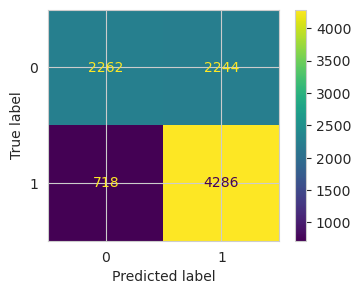

In [13]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
check_model(rf_model, df_train_features, df_train_targets)

# Выбор модели

Не знаю где это описать, пробовал все в разные моменты времени, ставил ночами разные грид-серчи. Если саму суть - в начале подобрал гиперпараметры случайного леса - работал только с ним, проверял на нем фичи. В какой-то момент устал что скор не растет - взял CatBoost - по-подбирал гиперпараметры. Выбрал два набора - 'быстрый' и  'хороший' для того чтобы разрабатывать решение и для того чтобы его сабмитить. Ниже, в supplementary, я оставил чанки с output'ом который также же как там уже не прогонится, но для иллюстрации.

Также CatBoost требует отдельно категориальные переменнные, вот они:

In [19]:
cat_cols = ['game_stage', 'game_mode', 'lobby_type',
            'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id',
            'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id']

Сперва я предобработую те фичи которые уже есть. Возьму суммы по командам, возьму отношение или разность этих сумм. В общем все зависит от фичи. Это все кропотливо сиделось и подбиралось в тонне прогонов тонны ячеек.

## Оценка и анализ фич

Здест я смотрю на фичи. Вообще че то много разных графиков было. И на этот зумился и по каждой фиче отдельно. В общем фич очень много так что не стал прям все сохранять. Там ниже есть прикольная штука с уровнем персонажа!

<class 'pandas.core.frame.DataFrame'>
Index: 31698 entries, b9c57c450ce74a2af79c9ce96fac144d to e2ca68ac1a6847f4a37f6c9c8ee8695b
Columns: 245 entries, game_time to d5_sen_placed
dtypes: float64(30), int64(215)
memory usage: 60.5+ MB
None
          game_time     game_mode    lobby_type  objectives_len      chat_len  \
count  31698.000000  31698.000000  31698.000000    31698.000000  31698.000000   
mean    1146.519496     19.583538      4.771563        6.535239      7.358982   
std      766.936655      6.306635      3.260899        6.486933     13.295763   
min        0.000000      2.000000      0.000000        0.000000      0.000000   
25%      521.000000     22.000000      0.000000        1.000000      0.000000   
50%     1044.000000     22.000000      7.000000        4.000000      3.000000   
75%     1659.000000     22.000000      7.000000       10.000000      9.000000   
max     4933.000000     23.000000      7.000000       43.000000    291.000000   

         r1_hero_id      r1_kill

<AxesSubplot:>

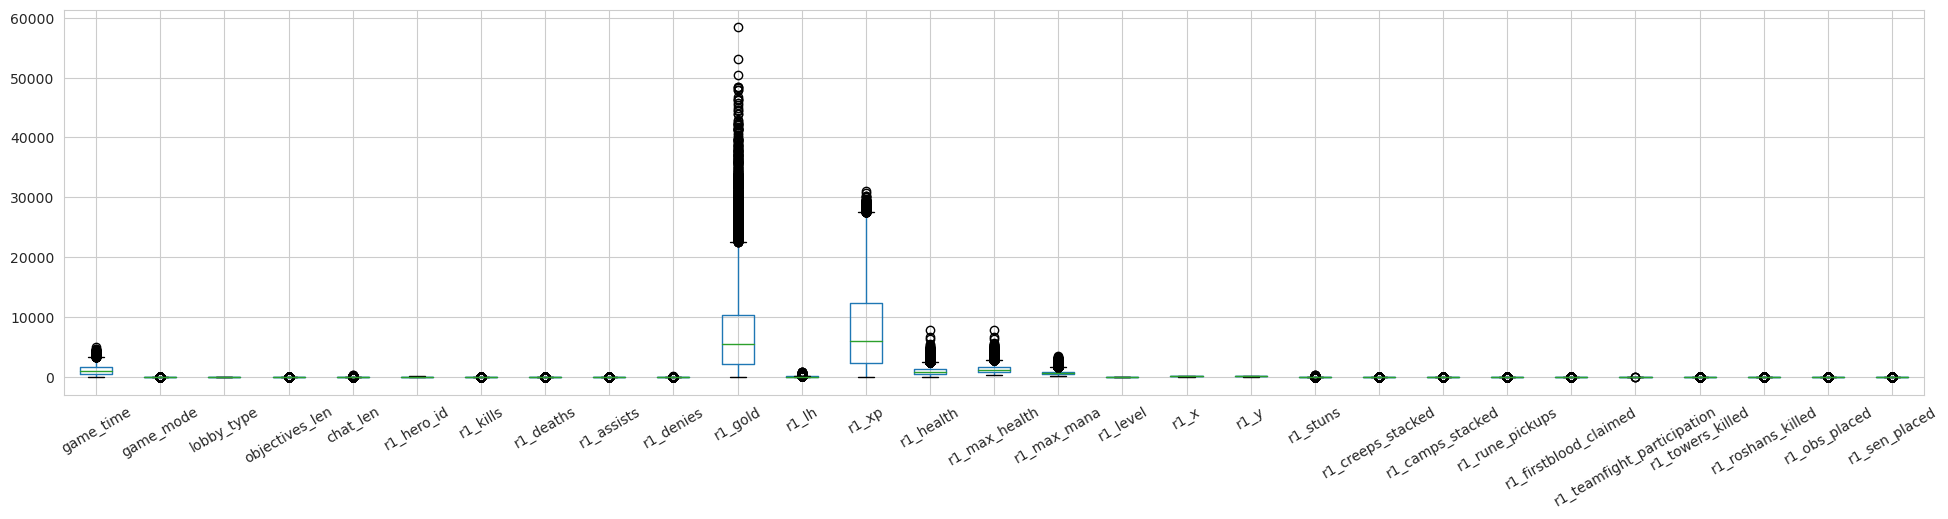

In [42]:
plt.rcParams["figure.figsize"] = 24, 5
print(df_train_features.info())
print(df_train_features.iloc[:, :29].describe())
df_train_features.iloc[:, :29].boxplot(rot=30)

#### Уровень персонажа.

Понятно что лучше больше чем меньше но все зависит как минимум от момента игры. Поэтому... я посмотрел на все уровни персонажей обеих команд в зависимости от времени - есть очевидный линейный тренд. Построил регрессию, получил коэффициент наклона  - это красная прямая. И далее я взял немного более строгую границу - зеленая прямая. И если уровень персонажа выше чем следует из зеленой прямой, то я говорю что он хорошо растет. Позже в моменте добавления фич я так ее и добавлю - уровень выше чем следовало бы из линейной модели.

[0.009268349228083873, 0.009314966820776451, 0.00922981997287162, 0.009291911053894323, 0.009254646175001262, 0.00926426968446335, 0.009264579676852978, 0.009279615998979371, 0.009230330856777765, 0.009241297799240355]


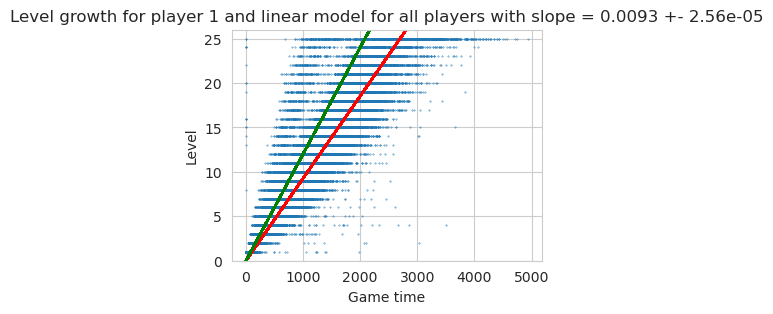

In [58]:
slopes = []
for p in range(1,6):
    for team in ['r', 'd']:
        player = team + str(p)
        res = sm.OLS(df_train_features[f'{player}_level'], df_train_features.game_time).fit()
        slopes.append(res.params.game_time)
print(slopes)
slope, slope_std = np.mean(slopes), np.std(slopes)
plt.scatter(df_train_features.game_time, df_train_features.r1_level, s=0.1)
plt.plot(x, slope*x, c='red')
plt.plot(x, 0.012*x, c='green')
plt.ylim(0, 26)
plt.ylabel('Level')
plt.xlabel('Game time')
plt.title(f'Level growth for player 1 and linear model for all players with slope = {slope:.4f} +- {slope_std:.2e}');

Ну также, например, строил всякие фичи и считал по сути таблицу сопряженности - сколько r > d в победных матчах и сколько в проигранных. Если сильно неравномерно - то значит хорошая фича. Чанк оставил скорее как музейный экспонат, но я с ним много всего разобрал / оставил / удалил. 

In [ ]:
for feature in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health','max_mana', 
                'stuns', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation', 
                'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']:
    print(feature)
    ddx = df_train_features_extended.filter(regex=f'r._{feature}').apply(sum, axis=1).to_frame()
    y = df_train_features_extended.filter(regex=f'd._{feature}').apply(sum, axis=1).to_frame()
    z = df_train_targets.radiant_win.to_frame()
    counts = x.merge(y, on='match_id_hash').apply(lambda x: x['0_x'] >  x['0_y'], axis=1).to_frame(name='r_over_d').merge(z, on='match_id_hash').apply(lambda x: x['r_over_d'] ==  x['radiant_win'], axis=1).to_frame().value_counts()
    print(counts)
    print('')

Пример: выводил данные типа:

`kills
True: 3000 # если больше убивал то победил - таких 3000
False 1000 # если больше убивал то проиграл - таких 1000`

Такое ощущение что стало неправильно работать после upsampling

## Функция для препроцессинга и генерации фич по уже имеющимся

Здесь получается суммировано все что имеется по модернизации фич внутри csv датасета. 
Много всего разного, приведу пару примеров того на что смотрел из интересного:

- `game_stage` - делю время игры на несколько промежутков по квантилям.
- `well_growing` = это то что обещал про сравнение с линейным ростом уровня
- `at_home` - смотрю по координатам x y назодится ли персонаж в левой-нижней половине карты или в правой-верхней
- `kde` - это понятно
- `lh_ratio` - здесь смотрю сколько крипов врага убито из тех что были убиты своей или чужой командой
- `health` - заменяю на относительную долю от максимального. При этом максимальное здоровье тоже остается

Ну и остальное, как можете видеть - где то брал отношение командных сумм, где то разность. 

Одна из основных задач была осмысленной обработкой Hero ID. Я посколько глубоко в Dota не шарю, то посчитал несколько основных статистик в среднем по всем матчам каждого героя.

In [46]:
heroes_chances = dict()
r_hero_cols = [f'r{i}_hero_id' for i in range(1,6)]
df_train_features['heroes_comb']= df_train_features[r_hero_cols].values.tolist()
for match in df_train_targets.index:
    match_heroes = df_train_features.loc[[match]]['heroes_comb'][0]
    for i, hero in enumerate(match_heroes):
        if hero not in heroes_chances:
            heroes_chances[hero] = [0,0,0,0,0,0]
        heroes_chances[hero][0] += 1
        heroes_chances[hero][3] += df_train_features.loc[[match]][f'r{i+1}_kills'][0]
        heroes_chances[hero][4] += df_train_features.loc[[match]][f'r{i+1}_gold'][0]
        heroes_chances[hero][5] += df_train_features.loc[[match]][f'r{i+1}_assists'][0]
        if df_train_targets.loc[[match]].radiant_win[0] == True:
            heroes_chances[hero][1] += 1
            
for hero in heroes_chances:
    heroes_chances[hero][2] = heroes_chances[hero][1]/heroes_chances[hero][0]
    heroes_chances[hero][3] = heroes_chances[hero][3]/heroes_chances[hero][0]
    heroes_chances[hero][4] = heroes_chances[hero][4]/heroes_chances[hero][0]
    heroes_chances[hero][5] = heroes_chances[hero][5]/heroes_chances[hero][0]

In [1]:
def feature_generation(df_X):
    try:
        df_X['game_stage'] = pd.qcut(df_X['game_time'], 4, labels = ['1','2','3','4'])
    except KeyError:
        print('Already preprocessed')
        return df_X
    
    teams = {
        'r': 'd',
        'd': 'r'
    }
    for us, they in teams.items():
        creeps_killed = df_X.filter(regex=f'{us}._lh').apply(sum, axis=1).to_frame()
        df_X[f'{us}_lh_ratio'] = creeps_killed /(1 + creeps_killed + df_X.filter(regex=f'{they}._denies').apply(sum, axis=1).to_frame())  
        
    for side in teams:
        for p in range(1,6):
            # здесь добавляю новые фичи каждому герою
            # золото скопировал потому что далее при процессинге фич они у меня удаляются
            # золото юзал дважды поэтому чтобы добавить в тот же цикл - продублировал
            df_X[f'{side}{p}_gold_copy'] = df_X[f'{side}{p}_gold']
            df_X[f'{side}{p}_kde'] = df_X.apply(lambda x: (x[f'{side}{p}_kills'] +  x[f'{side}{p}_assists'])/(x[f'{side}{p}_deaths'] + 1), axis=1)
            df_X[f'{side}{p}_at_home'] = df_X.apply(lambda x: int(abs(x[f'{side}{p}_y'] -  x[f'{side}{p}_x']) > 125), axis=1)
            df_X[f'{side}{p}_health'] = df_X[f'{side}{p}_health']/(df_X[f'{side}{p}_max_health'] + 1)
            df_X[f'{side}{p}_wards_placed'] = df_X.apply(lambda x: (x[f'{side}{p}_obs_placed'] +  x[f'{side}{p}_sen_placed']), axis=1)
            df_X[f'{side}{p}_well_growing'] = df_X.apply(lambda x: (x[f'{side}{p}_level'] > 0.013 * x['game_time']), axis=1)
            
            # здесь создаю фичи из средних значений по героям
            df_X[f'{side}{p}_hero_chance'] = df_X.apply(lambda x: heroes_chances[x[f'{side}{p}_hero_id']][2] , axis=1)
            df_X[f'{side}{p}_hero_chance_copy'] = df_X[f'{side}{p}_hero_chance']
            df_X[f'{side}{p}_hero_kills'] = df_X.apply(lambda x: heroes_chances[x[f'{side}{p}_hero_id']][3] , axis=1)
            df_X[f'{side}{p}_hero_assists'] = df_X.apply(lambda x: heroes_chances[x[f'{side}{p}_hero_id']][4], axis=1)
            df_X[f'{side}{p}_hero_gold'] = df_X.apply(lambda x: heroes_chances[x[f'{side}{p}_hero_id']][5] , axis=1)
            
    for side in teams:
        for p in range(1,6):      
            df_X[f'{side}{p}_level_diff'] = df_X.apply(lambda x: (x[f'{side}{p}_level'] - 0.0093 * x['game_time']), axis=1)
        df_X[f'{side}_level_diff'] = df_X.filter(regex=f'{side}._level_diff').apply(sum, axis=1).to_frame()
    
    # здесь для разных фич считаю mean и std по команде, удаляю исходные персональные фичи
    # здесь разность берется
    for feature in ['kills', 'deaths', 'assists', 'rune_pickups', 'creeps_stacked', 'camps_stacked', 'stuns', 'gold_copy', 'hero_kills', 'hero_assists']:
        r_sum = df_X.filter(regex=f'r._{feature}').apply(sum, axis=1).to_frame()
        d_sum = df_X.filter(regex=f'd._{feature}').apply(sum, axis=1).to_frame()
        df_X[feature + '_dominance'] = r_sum.merge(d_sum, on='match_id_hash').apply(lambda x: (x['0_x'] - x['0_y']), axis=1) 
        r_std = df_X.filter(regex=f'r._{feature}').apply(np.std, axis=1).to_frame()
        d_std = df_X.filter(regex=f'd._{feature}').apply(np.std, axis=1).to_frame()
        df_X[feature + '_dominance_std'] = r_std.merge(d_std, on='match_id_hash').apply(lambda x: (x['0_x'] - x['0_y']), axis=1) 
        for p in range(1,6):
            df_X.drop([f'r{p}_{feature}', f'd{p}_{feature}'], axis=1, inplace=True)
    
    # здесь тоже разность (другой цикл так как пробовал разное)
    for feature in ['firstblood_claimed', 'towers_killed', 'roshans_killed', 'level', 'wards_placed', 'well_growing', 'at_home']:
        r_sum = df_X.filter(regex=f'r._{feature}').apply(sum, axis=1).to_frame()
        d_sum = df_X.filter(regex=f'd._{feature}').apply(sum, axis=1).to_frame()
        df_X[feature + '_difference'] = r_sum.merge(d_sum, on='match_id_hash').apply(lambda x: x['0_x'] - x['0_y'], axis=1)
        r_std = df_X.filter(regex=f'r._{feature}').apply(np.std, axis=1).to_frame()
        d_std = df_X.filter(regex=f'd._{feature}').apply(np.std, axis=1).to_frame()
        df_X[feature + '_dominance_std'] = r_std.merge(d_std, on='match_id_hash').apply(lambda x: x['0_x'] - x['0_y'], axis=1) 
        for p in range(1,6):
            df_X.drop([f'r{p}_{feature}', f'd{p}_{feature}'], axis=1, inplace=True)
           
    # по этим фичам, так как они по сути являются долями - беру отношение
    for feature in ['teamfight_participation', 'kde', 'hero_chance_copy']:
        r_sum = df_X.filter(regex=f'r._{feature}').apply(sum, axis=1).to_frame()
        d_sum = df_X.filter(regex=f'd._{feature}').apply(sum, axis=1).to_frame()
        df_X[feature + '_ratio'] = r_sum.merge(d_sum, on='match_id_hash').apply(lambda x: x['0_x'] /max(x['0_y'] + x['0_x'], 1), axis=1)
        r_std = df_X.filter(regex=f'r._{feature}').apply(np.std, axis=1).to_frame()
        d_std = df_X.filter(regex=f'd._{feature}').apply(np.std, axis=1).to_frame()
        df_X[feature + '_ratio_std'] = r_std.merge(d_std, on='match_id_hash').apply(lambda x: x['0_x'] /max(x['0_y'] + x['0_x'], 1), axis=1)
        for p in range(1,6):
            df_X.drop([f'r{p}_{feature}', f'd{p}_{feature}'], axis=1, inplace=True) 
    
    # здесь отношение с  pseudocount в знаменателе чтобы не делить на 0 (для таких больших цифр как золото или xp это не страшно
    for feature in ['gold', 'xp', 'health', 'max_health','max_mana', 'hero_gold']:
        r_sum = df_X.filter(regex=f'r._{feature}').apply(sum, axis=1).to_frame()
        d_sum = df_X.filter(regex=f'd._{feature}').apply(sum, axis=1).to_frame()
        df_X[feature + '_ratio'] = r_sum.merge(d_sum, on='match_id_hash').apply(lambda x: x['0_x'] /(x['0_y'] + 1), axis=1)
        r_std = df_X.filter(regex=f'r._{feature}').apply(np.std, axis=1).to_frame()
        d_std = df_X.filter(regex=f'd._{feature}').apply(np.std, axis=1).to_frame()
        df_X[feature + '_ratio_std'] = r_std.merge(d_std, on='match_id_hash').apply(lambda x: x['0_x'] /(x['0_y'] + 1), axis=1)
        for p in range(1,6):
            df_X.drop([f'r{p}_{feature}', f'd{p}_{feature}'], axis=1, inplace=True) 
    
    # удаляю всякие ненужные шутки
    for side in teams:
        for p in range(1,6):
            df_X.drop([f'{side}{p}_x', f'{side}{p}_y', f'{side}{p}_denies', f'{side}{p}_lh', f'{side}{p}_obs_placed', f'{side}{p}_sen_placed', f'{side}{p}_level_diff'], axis=1, inplace=True)
    df_X.drop(['game_time'], axis=1, inplace=True)

## Добавление признаков из JSON

Тут очень много всего, постарался разобрать как можно больше. Почти каждую фичу гуглил, не рассматривал те которые прям откровенно дублировались с тем что уже в датасете. На каждую фичу смотрел примерно следующим образом: считал её сумму / длину / логическое значение в radian и в dire, после чего смотрел графически - есть ли разница в ее распределении у победителей/побежденных или нет. Для разных фичей функция разная в итоге была, но вот пример как это выглядело:

  0%|          | 0/31698 [00:00<?, ?it/s]

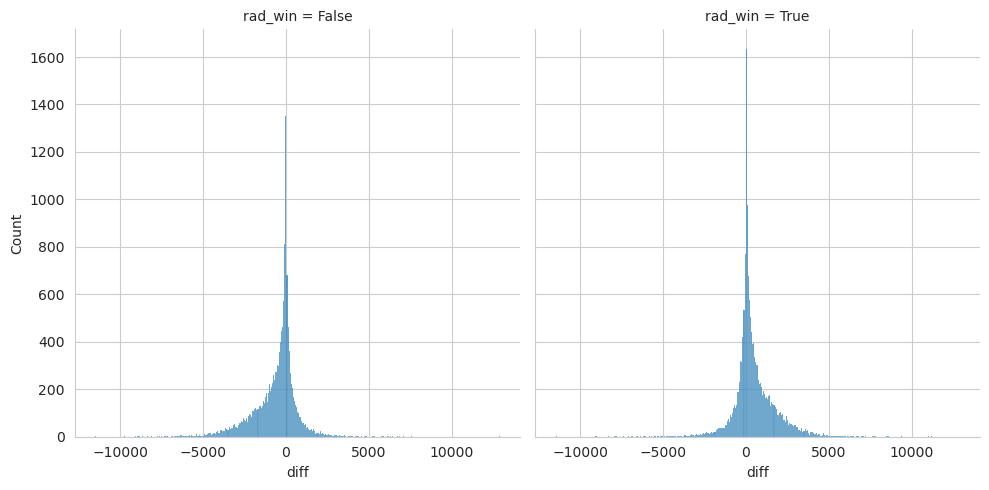

In [9]:
# здесь смотрю на gold_reasons  при чем на reason == '1' - то есть потеря золота от смерти. Считаю сумму потерь в каждой комаде.
var = 'gold_reasons'
matches = read_matches('/kaggle/input/bi-ml-competition-2023/train_raw_data.jsonl', total_matches=31698, n_matches_to_read=31698)
df_for_feature_check = pd.DataFrame(columns=('rad_win', 'diff'))
for match in matches:
    winner = match['targets']['radiant_win']
    r_abs, d_abs = 0, 0
    for player in match['players']:
        if player['player_slot'] < 128:
            for k, v in player[var].items():
                    r_abs += v if k == '1' else 0
        elif player['player_slot'] > 127:
            for k, v in player[var].items():
                d_abs += v if k == '1' else 0
    df_for_feature_check.loc[len(df_for_feature_check)] =[winner, r_abs - d_abs ]

sns.displot(data=df_for_feature_check, kind='hist', x='diff', col='rad_win')

Тут видим что у победителей и побежденных распрежеления немного разные, так что может быть полезным. Но так сравнивать сложно - строю на одном графике. Тут нагляднее видно, что кажется эта фича может помочь модели разделять победителей и побежденных

<AxesSubplot:xlabel='diff', ylabel='Count'>

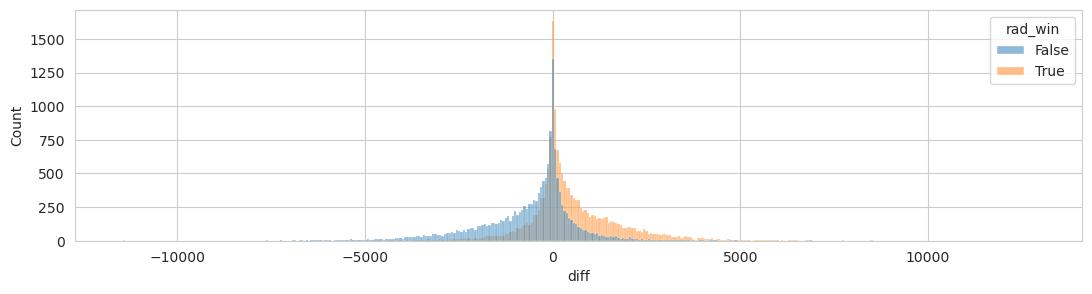

In [250]:
sns.histplot(data=df_for_feature_check, x='diff', hue='rad_win') 

Так вот я и смотрел все фичи несколько часов подряд. Что-то выбрал и включил далее, что-то отбросил.

Для некоторых фичей посмотрел какие значения вообще характерны для победителей чтобы проверять их наличия.
Одним проходом по JSON я считаю все элементы инвентаря и все покупочки которые ассоциированны с победой. За каждое появление у победителя делаю +1, за каждое появление у проигравшего ставлю -1. В итоге отобрал по 50 предметов с максимальным по модулю скором.

Как и с Hero ID, считаю лучшие предметы и покупки (которые ассоциированны с победами, беру по 50 лучших)

In [48]:
# purchases and items usefulness
purchases_usefulness = {}
items_usefulness = {}
matches = read_matches('/kaggle/input/bi-ml-competition-2023/train_raw_data.jsonl', total_matches=31698, n_matches_to_read=31698)
items_usefulness_df = pd.DataFrame(columns=('win', 'item'))
for match in matches:
    winner = match['targets']['radiant_win']
    win_coef = (int(winner) - 0.5)*2
    for player in match['players']:
        for item, number in player['purchase'].items():
            if item in items_usefulness:
                purchases_usefulness[item] += number*win_coef*(player['player_slot'] < 127)
            else:
                purchases_usefulness[item] = number*win_coef*(player['player_slot'] < 127)
        for item in player['hero_inventory']:
            item = item['id']
            if item in items_usefulness:
                items_usefulness[item] += number*win_coef*(player['player_slot'] < 127)
            else:
                items_usefulness[item] = number*win_coef*(player['player_slot'] < 127)
                
items_usefulness_list = sorted(items_usefulness.items(), key=lambda x:abs(x[1]), reverse=True)
purchases_usefulness_list = sorted(purchases_usefulness.items(), key=lambda x:abs(x[1]), reverse=True)
best_items = [x[0] for x in items_usefulness_list[:50]] 
best_purchases = [x[0] for x in purchases_usefulness_list[:50]]

  0%|          | 0/31698 [00:00<?, ?it/s]

Теперь добавляю все фичи из JSON которые мне показались полезными (с учетом upsampling!)

In [7]:
def count_teams_objectives(obj_type, match):
    """
    Here for objectives field in JSON
    """
    radiant_count, dire_count = 0, 0
    for objective in match["objectives"]:
        if objective["type"] == obj_type:
            if 'team' in objective:
                if objective["team"] == 2:
                    radiant_count += 1
                if objective["team"] == 3:
                    dire_count += 1 
            elif 'player_slot' in objective:
                if objective["player_slot"] < 128:
                    radiant_count += 1
                if objective["player_slot"] > 127:
                    dire_count += 1                     
    return radiant_count - dire_count
    
def count_team_features_diff(feature, match, fun=None, shift=0, k_true=('1')):
    """
    Here for players field in JSON
    """
    radiant_count, dire_count = 0, 0
    for player in match['players']:
        if player['player_slot'] < 128:
            radiant_count += count_player_features(player, feature, fun, shift, k_true) 
        if player['player_slot'] > 127:
            dire_count +=  count_player_features(player, feature, fun, shift, k_true)    
    return radiant_count - dire_count


def  count_player_features(player, feature, fun, shift, k_true):
    if fun == 'bool':
        return player[feature]
    
    if fun == 'len':    
        return len(player[feature])
    
    if fun == 'v':
        return sum(player[feature].values())
    
    if fun =='kv':
        kv = 0
        for k, v in player[feature].items():
            kv += (int(k)+shift)*v 
        return kv
    
    if fun == 'best_item':
        n = 0
        for k in player[feature]:
            n += int(k['id'] in best_items)
        return n
    
    if fun == 'best_purchase':
        n = 0
        for k in player[feature]:
            n += int(k in best_items)
        return n   
        
    if fun =='v_if_k':
        kv = 0
        for k, v in player[feature].items():
            kv += v if k in k_true else 0
        return kv
        
def add_new_features(df_features, matches_file, data_type='train'):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    upsampling_params = {'': 1}
    n_matches_to_read = None
    if data_type == 'train':
        upsampling_params['_r'] =  -1
    else: 
        n_matches_to_read = 7977
    
    for match in read_matches(matches_file, n_matches_to_read=n_matches_to_read):
        for k, v in upsampling_params.items():
            match_id_hash = match['match_id_hash'] + k
            
            
            # здесь по некоторым фичам считаю разницу между командами
            # умножение на v - для upsamplinga (равно -1 у diar)
            # по команде считаю разные метрики. в JSON обычно все словарями
            # len - считаю длину словаря (=кол-во событий)
            # v - считаю сумму значений в словаре (=общий прирост/потеря денег/здоровья... по всем событиям)
            # kv - умножаю ключ на значение (актуально когда ключ это 0 1 2 3 означает кратность значения)
            # v_if_k считаю значения с условем на ключ
            # best_item, best_purchase - считаю количество покупок/элементов из самых полезных которые вытащил из статистики по всем матчам
            df_features.loc[match_id_hash, "diff_aegis"] = v * count_teams_objectives("CHAT_MESSAGE_AEGIS", match)
            df_features.loc[match_id_hash, "diff_ablts"] = v * count_team_features_diff('ability_upgrades', match, 'len')   
            df_features.loc[match_id_hash, "diff_hst"] = v * count_team_features_diff('hero_stash', match, 'len')   
            df_features.loc[match_id_hash, "diff_bblogs"] = v * count_team_features_diff('buyback_log', match, 'len')   
            df_features.loc[match_id_hash, "diff_hhits"] = v * count_team_features_diff('hero_hits', match, 'v')   
            df_features.loc[match_id_hash, "diff_healing"] = v * count_team_features_diff('healing', match, 'v')  
            df_features.loc[match_id_hash, "diff_life_state"] = v * count_team_features_diff('life_state', match, 'kv')   
            df_features.loc[match_id_hash, "diff_multi_kills"] = v * count_team_features_diff('multi_kills', match, 'kv')   
            df_features.loc[match_id_hash, "diff_purchase_items"] = v * count_team_features_diff('purchase', match, 'v')    
            df_features.loc[match_id_hash, "diff_purchase_variants"] = v * count_team_features_diff('purchase', match, 'len')  
            df_features.loc[match_id_hash, "diff_actions"] = v * count_team_features_diff('actions', match, 'kv', shift=-1)   
            df_features.loc[match_id_hash, "diff_hero_hits"] = v * count_team_features_diff('hero_hits', match, 'len')    
            df_features.loc[match_id_hash, "diff_hero_inventory"] = v * count_team_features_diff('hero_inventory', match, 'len')  
            df_features.loc[match_id_hash, "diff_purchase_log"] = v * count_team_features_diff('purchase_log', match, 'len')  
            df_features.loc[match_id_hash, "diff_item_uses"] = v * count_team_features_diff('item_uses', match, 'v')  
            df_features.loc[match_id_hash, "diff_hero_inventory"] = v * count_team_features_diff('hero_inventory', match, 'best_item') 
            df_features.loc[match_id_hash, "diff_purchase"] = v * count_team_features_diff('purchase', match, 'best_purchase')  
            df_features.loc[match_id_hash, "diff_gold_loses_deaths"] = v * count_team_features_diff('gold_reasons', match, 'v_if_k') 
            df_features.loc[match_id_hash, "diff_gold_teammates"] = v * count_team_features_diff('gold_reasons', match, 'v_if_k', k_true=('5')) 
            df_features.loc[match_id_hash, "diff_gold_gets_kills"] = v * count_team_features_diff('gold_reasons', match, 'v_if_k', 
                                                                                        k_true=('11', '12', '13', '14' '15') )

# Feature generation

Понятное дело, что я все это тестировал миллион раз миллион лет миллион ячеек каждую фичу. Но под конец я сам уже стал треяться в ноутбуке (точнее, в середине где-то уже) - так что я все собрал в одно финально оформленное место. Тут я делаю:
- Сперва делаю upsampling (меняю radian и dire местами, записываю в датасет с match_id = match_id + '_r'
- Потом запускаю функцию по обработке фич тех что в датасете
- Потом запускаю функцию которая вытягивает еще фич из JSON

In [50]:
df_train_features.shape

(31698, 246)

In [51]:
df_features_reversed = df_train_features.copy()
df_targets_reversed =  df_train_targets.copy()
df_targets_reversed.radiant_win =  - df_train_targets.radiant_win
new_columns = [re.sub(r'^r', 'x', i) for i in df_features_reversed.columns]
new_columns = [re.sub(r'^d', 'r', i) for i in new_columns]
new_columns =[re.sub(r'^x', 'd', i) for i in new_columns]
df_features_reversed.columns = new_columns
df_targets_reversed.index = df_targets_reversed.index +'_r'
df_features_reversed.index = df_features_reversed.index +'_r'
df_train_features = pd.concat([df_train_features, df_features_reversed])
df_train_targets = pd.concat([df_train_targets, df_targets_reversed])

In [52]:
df_train_features_extended = df_train_features.copy()
df_test_features_extended = df_test_features.copy()
feature_generation(df_train_features_extended)
feature_generation(df_test_features_extended)
add_new_features(df_train_features_extended, 
                '/kaggle/input/bi-ml-competition-2023/train_raw_data.jsonl')
add_new_features(df_test_features_extended, 
                '/kaggle/input/bi-ml-competition-2023/test_raw_data.jsonl', data_type='test')

if 'heroes_comb' in df_train_features_extended.columns:
    df_train_features_extended.drop(['heroes_comb'], axis=1, inplace=True)

  0%|          | 0/31698 [00:00<?, ?it/s]

  0%|          | 0/31698 [00:00<?, ?it/s]

In [55]:
df_train_features_extended.shape

(63396, 100)

In [56]:
df_train_features_extended.to_csv('train_extended_data.csv')
df_test_features_extended.to_csv('test_extended_data.csv')
df_train_targets.to_csv('train_extended_targets.csv')

In [8]:
df_train_features_extended = pd.read_csv('/kaggle/input/processed-features-data-2/train_extended_data.csv', 
                                    index_col="match_id_hash")
df_test_features_extended = pd.read_csv('/kaggle/input/processed-features-data-2/test_extended_data.csv', 
                                   index_col="match_id_hash")
df_train_targets = pd.read_csv('/kaggle/input/processed-features-data-2/train_extended_targets.csv', 
                               index_col="match_id_hash")

Проверял я все это на CatBoost c 650 итерациями:

In [ ]:
cb_model = CatBoostClassifier(iterations=650,
                           depth=7, learning_rate=0.03,
                            loss_function= 'CrossEntropy',
                           l2_leaf_reg = 0.9,   
                            score_function = 'L2', 
                            cat_features = cat_cols,
                            verbose = False  
                             )
check_model(cb_model, df_train_features_extended, df_train_targets)

In [ ]:
plt.rcParams["figure.figsize"] = 13, 3
plt.scatter(cb_model.feature_names_,cb_model.feature_importances_);
plt.xticks(rotation=85);

## Проверка колонок на содержание NA после трансформаций

In [14]:
df_train_features_extended[df_train_features_extended.isna().any(axis=1)].columns[df_train_features_extended.isnull().any()]

Index([], dtype='object')

### Финальная модель

In [20]:
cb_model = CatBoostClassifier(iterations=1200,
                           depth=8, learning_rate=0.015,
                            loss_function= 'CrossEntropy',
                           l2_leaf_reg = 0.85,   
                            score_function = 'L2', 
                            cat_features = cat_cols,
                            verbose = False  
                             )

ROC-AUC score на отложенной части: 0.8436056932744045


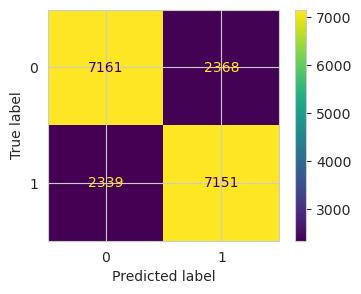

In [63]:
check_model(cb_model, df_train_features_extended, df_train_targets)

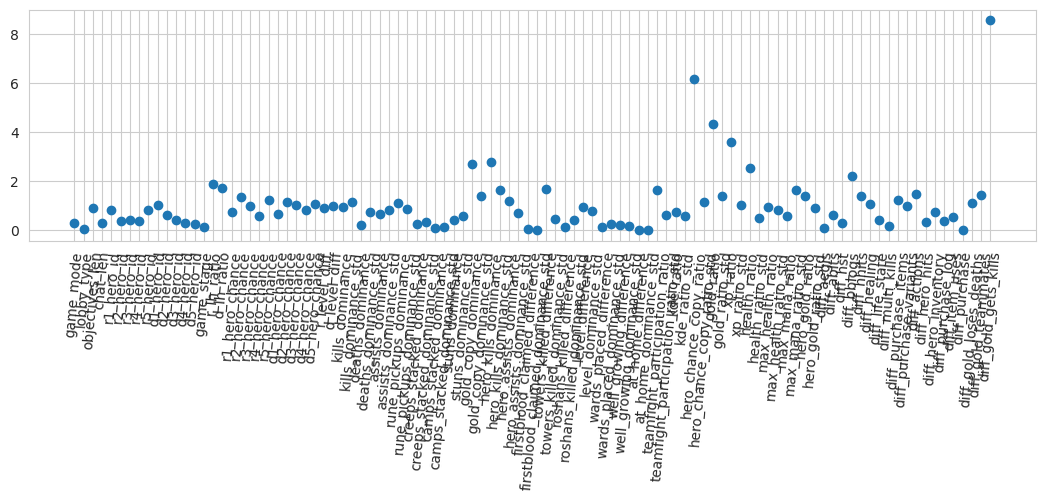

In [64]:
plt.rcParams["figure.figsize"] = 13, 3
plt.scatter(cb_model.feature_names_,cb_model.feature_importances_);
plt.xticks(rotation=85);

## Отправка посылки

In [89]:
%%time
отправь_посылку(cb_model,  df_train_features_extended, df_train_targets, X_df=df_test_features_extended)

Файл посылки сохранен, как: submission.csv


## Supplementary

Здесь есть салат из нескольких вещей которые я тоже пробовал, но не принесли супер хорошего результата

Поделал GridSearch на LGBM, LR и XGB, хотел сделать voting classifier. Получилось не сильно лучше чем catboost который гуляет сам по себе, так что убрал это в supplementary.

### LBGM

In [15]:
lgbm = LGBMClassifier(random_state=SEED, n_jobs=-1,
                      learning_rate=0.2, max_depth=6, n_estimators=40, num_leaves=100,
                       objective='binary', reg_alpha=0.8, reg_lambda=0.35)
check_model(lgbm, df_train_features_extended, df_train_targets, to_plot=False)

### XGB

In [16]:
xgb = XGBClassifier(random_state=SEED, n_jobs=-1, max_bin=10, max_leaves=0,
                      learning_rate=0.2, max_depth=5, n_estimators=40, reg_alpha=1, reg_lambda=1, gamma=0)
check_model(xgb, df_train_features_extended, df_train_targets, to_plot=False)

### LR

In [13]:
lr = LogisticRegression(n_jobs=-1, random_state=SEED, C=1000, max_iter=1200, penalty='l2', solver='newton-cg', fit_intercept=True)
check_model(lr, df_train_features_extended, df_train_targets, to_plot=False)м

ROC-AUC score на отложенной части: 0.8409616321802195


Вот эту модель по сути сабмитил которая вышла лучшей (видимо не нашел совсем идеальных параметров для LGBM,c ним было хуже):

In [27]:
estimators =  [("LR", lr), ("XGB", xgb), ("CAT", cb_model)]

for voting in ['soft']:
    print(voting)
    voting_cls = VotingClassifier(estimators=estimators, voting = voting, n_jobs=-1)
    check_model(voting_cls, df_train_features_extended, df_train_targets, to_plot=False)
    отправь_посылку(voting_cls,  df_train_features_extended, df_train_targets, X_df=df_test_features_extended)

soft
ROC-AUC score на отложенной части: 0.8441892593194243
Файл посылки сохранен, как: submission.csv


### Grid Search LinReg

In [9]:
lr = LogisticRegression(n_jobs=-1, random_state=SEED)
'''
‘lbfgs’ - [‘l2’, None]
‘liblinear’ - [‘l1’, ‘l2’]
‘newton-cg’ - [‘l2’, None]
‘newton-cholesky’ - [‘l2’, None]
‘sag’ - [‘l2’, None]
‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None]
'''

lr_grid={
    "C":[1, 1000, 10000],
    "penalty":["l2"],
    "max_iter":[100, 1000],
    "solver": ["lbfgs", "liblinear", "newton-cg"],
     'fit_intercept': [True, False]
    }

gs_lr = GridSearchCV(lr, param_grid=lr_grid, cv=2, verbose=1)
gs_lr.fit(df_train_features_extended, df_train_targets.radiant_win.values.astype('int8'))

Fitting 2 folds for each of 36 candidates, totalling 72 fits


/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/mod

GridSearchCV(cv=2, estimator=LogisticRegression(n_jobs=-1, random_state=10801),
             param_grid={'C': [1, 1000, 10000], 'fit_intercept': [True, False],
                         'max_iter': [100, 1000], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg']},
             verbose=1)

In [10]:
print(gs_lr.best_estimator_)
check_model(gs_lr.best_estimator_, df_train_features_extended, df_train_targets, to_plot=False)

LogisticRegression(C=1000, max_iter=1000, n_jobs=-1, random_state=10801,
                   solver='newton-cg')
ROC-AUC score на отложенной части: 0.8409480526474504


### Grid Search LGBM

In [35]:
lgbm = LGBMClassifier(random_state=SEED, n_jobs=-1)
cv = KFold(n_splits=3, shuffle=True, random_state=SEED)
lgbm_grid = {
    'max_depth': [6],
    'n_estimators':[25, 30, 35, 40, 45, 50],
    'learning_rate':[0.2],
    'num_leaves': [100],
    'reg_alpha': [0.8],
    'reg_lambda': [0.35],
    }

gs_lgbm = GridSearchCV(lgbm, param_grid=lgbm_grid, cv=cv, verbose=1)
gs_lgbm.fit(df_train_features_extended, df_train_targets.radiant_win.values.astype('int8'))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=10801, shuffle=True),
             estimator=LGBMClassifier(learning_rate=0.2, max_depth=6,
                                      n_estimators=30, num_leaves=100,
                                      objective='binary', random_state=10801,
                                      reg_alpha=0.8, reg_lambda=0.35),
             param_grid={'learning_rate': [0.2], 'max_depth': [6],
                         'n_estimators': [25, 30, 35, 40, 45, 50],
                         'num_leaves': [100], 'reg_alpha': [0.8],
                         'reg_lambda': [0.35]},
             verbose=1)

In [36]:
print(gs_lgbm.best_estimator_)
check_model(gs_lgbm.best_estimator_, df_train_features_extended, df_train_targets, to_plot=False)

LGBMClassifier(learning_rate=0.2, max_depth=6, n_estimators=40, num_leaves=100,
               objective='binary', random_state=10801, reg_alpha=0.8,
               reg_lambda=0.35)
ROC-AUC score на отложенной части: 0.8396392311817034


### Grid Search XGB

In [57]:
xgb = XGBClassifier(random_state=SEED, n_jobs=-1)

xgb_grid = {
    'max_depth': [5],
    'n_estimators':[20],
    'learning_rate': [0.2],
    'reg_alpha': [1],
    'reg_lambda': [1],
    'gamma': [0],
    'max_leaves': [0, 1, 10],
    'max_bin': [10, 100, 200, 240, 256]
    }


xgb_gs = GridSearchCV(xgb, param_grid=xgb_grid, cv=2, verbose=1)
xgb_gs.fit(df_train_features_extended, df_train_targets.radiant_win.values.astype('int8'))

Fitting 2 folds for each of 15 candidates, totalling 30 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                          

In [58]:
print(xgb_gs.best_estimator_)
check_model(xgb_gs.best_estimator_, df_train_features_extended, df_train_targets, to_plot=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=10, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20,
              n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=10801, reg_alpha=1, reg_lambda=1, ...)
ROC-AUC score на отложенной части: 0.8383943319384086


### Проверка нужности каждой фичи

In [39]:
cb_model = CatBoostClassifier(iterations=650,
                           depth=7, learning_rate=0.03,
                            loss_function= 'CrossEntropy',
                           l2_leaf_reg = 0.9,   
                            score_function = 'L2', 
                            cat_features = cat_cols,
                            verbose = False  
                             )

base_score = check_model(cb_model, df_train_features_extended, df_train_targets, 
            to_plot=False, to_return_score=True)

features_test = pd.DataFrame(columns=('feature', 'score', 'diff'))
for feature in df_train_features_extended.columns:
    df_for_feature_test = df_train_features_extended.drop([feature], axis=1, inplace=False)
    
    cats = [x for x in cat_cols if x != feature]
    cb_model = CatBoostClassifier(iterations=650,
                           depth=7, learning_rate=0.03,
                            loss_function= 'CrossEntropy',
                           l2_leaf_reg = 0.9,   
                            score_function = 'L2', 
                            cat_features = cats,
                            verbose = False  
                             )
    score = check_model(cb_model, df_for_feature_test, df_train_targets, 
                            to_plot=False, to_return_score=True)
    features_test.loc[len(features_test)] = [feature, score, score - base_score]

ROC-AUC score на отложенной части: 0.8433157348633825
ROC-AUC score на отложенной части: 0.8429129491129126
ROC-AUC score на отложенной части: 0.8430617268277937
ROC-AUC score на отложенной части: 0.8436647001040914
ROC-AUC score на отложенной части: 0.8438919914042
ROC-AUC score на отложенной части: 0.84269514579254
ROC-AUC score на отложенной части: 0.8432634403923203
ROC-AUC score на отложенной части: 0.8431250132007877
ROC-AUC score на отложенной части: 0.8431752397788306
ROC-AUC score на отложенной части: 0.8434078611561335
ROC-AUC score на отложенной части: 0.8432749852068241
ROC-AUC score на отложенной части: 0.8431321236564638
ROC-AUC score на отложенной части: 0.8428723432136229
ROC-AUC score на отложенной части: 0.843116111308378
ROC-AUC score на отложенной части: 0.8436204007488205
ROC-AUC score на отложенной части: 0.8431908319133617
ROC-AUC score на отложенной части: 0.8436434129700683
ROC-AUC score на отложенной части: 0.8434797066157427
ROC-AUC score на отложенной части:

In [45]:
features_test.to_csv('features_test.cvs')
features_test.sort_values(by='score', ascending=False).head(20)

,feature,score,diff
3,chat_len,0.843892,0.000576
95,diff_item_uses,0.843881,0.000566
59,well_growing_difference,0.843847,0.000531
79,hero_gold_ratio,0.843835,0.000519
46,hero_kills_dominance_std,0.843833,0.000517
89,diff_purchase_items,0.843812,0.000497
24,d3_hero_chance,0.843794,0.000478
26,d5_hero_chance,0.843788,0.000472
80,hero_gold_ratio_std,0.843763,0.000447
78,max_mana_ratio_std,0.843759,0.000444


ROC-AUC score на отложенной части: 0.8438327634094845


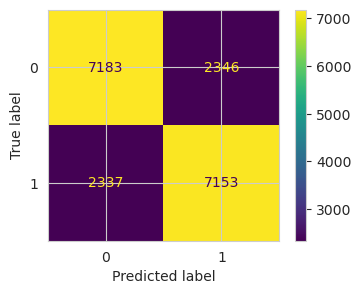

In [50]:
df_for_feature_test = df_train_features_extended.drop(['chat_len', 'diff_item_uses', 'hero_gold_ratio'], axis=1, inplace=False)
cb_model = CatBoostClassifier(iterations=1200,
                           depth=8, learning_rate=0.015,
                            loss_function= 'CrossEntropy',
                           l2_leaf_reg = 0.85,   
                            score_function = 'L2', 
                            cat_features = cat_cols,
                            verbose = False  
                             )
check_model(cb_model, df_for_feature_test, df_train_targets)

## Pseudo-labeling

Попробовал сделать тренирову на test_features которые предсказываю для отправки. Не дало улучшения скора. 

In [37]:
cb_model = CatBoostClassifier(iterations=1200,
                           depth=8, learning_rate=0.015,
                            loss_function= 'CrossEntropy',
                           l2_leaf_reg = 0.85,   
                            score_function = 'L2', 
                            cat_features = cat_cols,
                            verbose = False  
                             )

X = df_train_features_extended
y = df_train_targets["radiant_win"].astype("int8")
cb_model.fit(X, y)
y_pred = cb_model.predict(df_test_features_extended)
y_pred = pd.DataFrame(y_pred, columns = ['radiant_win'], index = df_test_features_extended.index) 
X_pseudo_total = pd.concat([df_train_features_extended, df_test_features_extended])
y_pseudo_total = pd.concat([df_train_targets, y_pred])

отправь_посылку(cb_model,  X_pseudo_total, y_pseudo_total, X_df=df_test_features_extended)

Файл посылки сохранен, как: submission.csv


In [149]:
df_train_features_extended

,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,...,diff_purchase_variants,diff_actions,diff_hero_hits,diff_hero_inventory,diff_purchase_log,diff_item_uses,diff_purchase,diff_gold_loses_deaths,diff_gold_teammates,diff_gold_gets_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,4,0,3,10,15,96,27,63,89,58,...,8.0,17945.0,4.0,6.0,16.0,36.0,0.0,893.0,-1036.0,6331.0
6db558535151ea18ca70a6892197db41,23,0,0,0,101,51,44,49,53,18,...,2.0,-204.0,0.0,5.0,3.0,-1.0,0.0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,22,7,0,0,57,10,81,98,119,48,...,4.0,1018.0,4.0,5.0,5.0,-3.0,0.0,0.0,0.0,167.0
c96d629dc0c39f0c616d1949938a6ba6,22,0,1,0,119,71,44,35,108,47,...,8.0,17024.0,-1.0,0.0,11.0,34.0,0.0,-307.0,0.0,877.0
156c88bff4e9c4668b0f53df3d870f1b,22,7,2,2,12,49,91,114,50,51,...,8.0,-265.0,-3.0,3.0,-8.0,40.0,0.0,-207.0,0.0,-324.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8_r,22,0,23,8,14,86,17,48,102,99,...,14.0,3534.0,6.0,-4.0,43.0,204.0,0.0,3431.0,0.0,11597.0
308faee28efee2e66b39f9f2ba6ea9cf_r,22,0,15,5,105,59,51,19,31,22,...,-3.0,-31493.0,5.0,-3.0,-2.0,-152.0,0.0,-2048.0,0.0,-8137.0
6066cc7417b43c749d551e123d00f0c8_r,4,0,4,0,41,119,99,64,97,1,...,13.0,-20249.0,4.0,1.0,7.0,53.0,0.0,1322.0,0.0,3861.0


### Random Forest Grid Search

Не дал каких то результатов отличных, остановился на: ` RandomForestClassifier(n_estimators=700, max_depth=30, criterion='entropy', n_jobs=-1, random_state=SEED)`

чанк принял ислам

###  Подбор параметров CatBoost:

For submission: `1200 iterations`, `8 depth`, `0.015 learning rate`, `0.85 l2_leaf reg`, `L2 score functions`, `CrossEntropy loss_function`

For tests: `850 iterations`, `7 depth`, `0.03 learning rate`, `0.9 l2_leaf reg`, `L2 score functions`, `CrossEntropy loss_function`

Делал циклом потому что Kaggle за ночь вырубается, так что делаю с печатью в дата-фрейм чтобы на утро можно было глянуть резы.
Гиперпараметры CatBoost подбирал в много заходов, ниже график-пример как я смотрел на это дело.

In [11]:
%%time
cols = ['Iterations', 'Depth', 'Learning_Rate', 'L2_leaf_reg', 'Score']
scores = pd.DataFrame(columns=cols)
for it in [850, 1200]:
    for d in [6, 7 ,8]:
        for l_r in [0.015, 0.02, 0.025, 0.3]:
            for l2 in [0.75, 0.8, 0.85, 0.9]:
                print(f'{it}, {d}, {l_r}, {l2}', end=' \t ')
                cb_model = CatBoostClassifier(iterations=it,
                                           depth=d, learning_rate=l_r,
                                            loss_function= 'CrossEntropy',
                                            l2_leaf_reg = l2,   
                                              score_function = 'L2',
                                             cat_features = cat_cols,
                                              verbose=False,
                                             )
                score = check_model(cb_model, df_train_features_extended, df_train_targets, 
                                    to_plot=False, to_return_score=True)
                scores.loc[len(scores)]  = [it, d, l_r, l2, score]

850, 6, 0.015, 0.75 	 ROC-AUC score на отложенной части: 0.8287351428245052
850, 6, 0.015, 0.8 	 ROC-AUC score на отложенной части: 0.82880825998303
850, 6, 0.015, 0.85 	 ROC-AUC score на отложенной части: 0.8285094107378497
850, 6, 0.015, 0.9 	 ROC-AUC score на отложенной части: 0.8286496183078641
850, 6, 0.02, 0.75 	 ROC-AUC score на отложенной части: 0.8291664146306859
850, 6, 0.02, 0.8 	 ROC-AUC score на отложенной части: 0.8294669447300852
850, 6, 0.02, 0.85 	 ROC-AUC score на отложенной части: 0.8295488089654994
850, 6, 0.02, 0.9 	 ROC-AUC score на отложенной части: 0.8293838309122581
850, 6, 0.025, 0.75 	 ROC-AUC score на отложенной части: 0.829876177441145
850, 6, 0.025, 0.8 	 ROC-AUC score на отложенной части: 0.8301029600616874
850, 6, 0.025, 0.85 	 ROC-AUC score на отложенной части: 0.8298943903812674
850, 6, 0.025, 0.9 	 ROC-AUC score на отложенной части: 0.8298982607692715
850, 6, 0.3, 0.75 	 ROC-AUC score на отложенной части: 0.8090866094416898
850, 6, 0.3, 0.8 	 ROC-AUC 

In [33]:
pd.concat([pd.read_csv('/kaggle/input/catboost-gridseacrh/catboost_700_850_1000_1200.csv'),
pd.read_csv('/kaggle/input/catboost-gridseacrh/catboost_850_1200.csv')]).sort_values(by='Score', ascending=False).head(15)

,Unnamed: 0,Iterations,Depth,Learning_Rate,L2_leaf_reg,Score
82,82,1200.0,8.0,0.015,0.85,0.830891
70,70,1200.0,7.0,0.020,0.85,0.830659
57,57,1200.0,6.0,0.025,0.80,0.830575
85,85,1200.0,8.0,0.020,0.80,0.830554
87,87,1200.0,8.0,0.020,0.80,0.830554
83,83,1200.0,8.0,0.015,0.90,0.830552
63,63,1000.0,8.0,0.020,0.80,0.830546
56,56,1200.0,6.0,0.025,0.75,0.830537
138,138,900.0,7.0,0.030,0.90,0.830521
31,31,850.0,7.0,0.030,0.90,0.830511


In [28]:
scores.to_csv('catboost_850_1200.csv')
scores.sort_values(by='Score', ascending=False).head(15)

,Iterations,Depth,Learning_Rate,L2_leaf_reg,Score
82,1200.0,8.0,0.015,0.85,0.830891
70,1200.0,7.0,0.020,0.85,0.830659
57,1200.0,6.0,0.025,0.80,0.830575
85,1200.0,8.0,0.020,0.80,0.830554
83,1200.0,8.0,0.015,0.90,0.830552
56,1200.0,6.0,0.025,0.75,0.830537
74,1200.0,7.0,0.025,0.85,0.830489
73,1200.0,7.0,0.025,0.80,0.830464
59,1200.0,6.0,0.025,0.90,0.830424
64,1200.0,7.0,0.015,0.75,0.830406


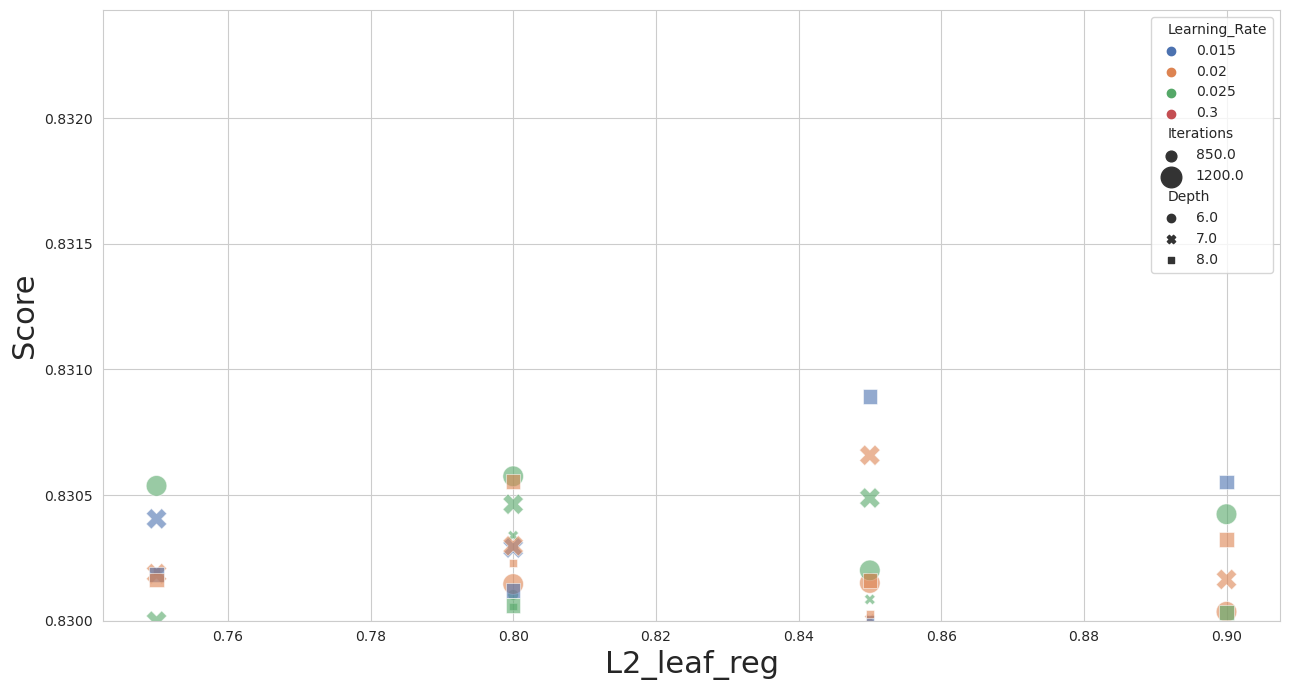

In [23]:
plt.rcParams["figure.figsize"] = 13, 7 
fig, ax = plt.subplots()
x = 'L2_leaf_reg'
sns.scatterplot(data=scores, x=x, y='Score', hue = 'Learning_Rate', style = 'Depth',
            size='Iterations', sizes=(60, 220), legend="full", alpha=0.6, palette='deep')   
plt.xlabel(x, fontsize=22)
plt.ylabel('Score', fontsize=22)
plt.ylim(0.830,)
# plt.xlim(0,0.04)
plt.tight_layout()